# LSTM-MPC for Evaporator: Setpoint Tracking

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries for Pyomo (for simulation only)
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np
import cyipopt
import json

import keras
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K

## Load the identified Model

In [2]:
lstm_mdl = load_model('evap_lstm.keras')

# Show the model architecture
lstm_mdl.summary()

# Turn the LSTM model into a concrete function
input_spec = tf.TensorSpec([None, 15, 6], dtype=tf.float32)
lstm_func = tf.function(lstm_mdl).get_concrete_function(input_spec)

# Use Tensorflow's XLA (Accelerated Linear Algebra) for faster inference
@tf.function(jit_compile=True)
def lstm_predict(x):
    return lstm_func(tf.cast(x, tf.float32))

# Load standard scaler scales and means from training
# Columns: [F200, P100, F3, L2, P2, X2]
YI, UI = np.array([3, 4, 5]), np.array([0, 1, 2])
scale_ = np.array([30.52634951, 27.30680801, 3.31043849, 0.12226375, 2.27643356, 4.95861316])
mean_ = np.array([204.82968912, 196.14955658, 49.74290531, 1.0075573, 50.58551774, 25.41497448])

Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 15, 12)            912       
                                                                 
 dense_104 (Dense)           (None, 15, 3)             39        
                                                                 
Total params: 951 (3.71 KB)
Trainable params: 951 (3.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Pyomo simulation of First-principles DAE

In [3]:
def solve_model(ti, tf, F200data, P100data, F3data, N_hor, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Manipulated variable to control L2 via P-control
    evap.F2 = Var(evap.t, initialize=2)
    
    # Inputs and Disturbances
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)

    evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.F3 = Param(evap.t, mutable=True)    # Input to be manipulated

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=1)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=N_hor, ncp=3, scheme='LAGRANGE-RADAU')

    # P-controller
    def _p_control(m, i):
        if i > m.ti:
            return m.F2[i] == 2 + 5*(m.L2[m.t.prev(i)] - 1.0)
        else:
            return m.F2[i] == init_data['F2']

    evap.p_control = Constraint(evap.t, rule=_p_control)
    
    # Step change data
    timepoints = list(evap.t)
    i_data = np.arange(ti, tf)
        
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        evap.F200[t] = F200data[pos][0]
        evap.P100[t] = P100data[pos][0]
        evap.F3[t] = F3data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        if v.name == 'L2' or v.name == 'P2' or v.name == 'X2'\
           or v.name[0] == 'd' or v.name == 'F2':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'F200' or v.name == 'P100' or v.name == 'F3':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res

In [4]:
def sim_mpc(uy0, u):
    # Shape of uy0: [look_back x n_u+n_y] (not scaled)
    # Shape of u:   [N_hor x n_u] (not scaled)
    
    # u includes the initial state u0
    
    K.clear_session() # Reset Keras memory

    N = u.shape[0] # This is N_hor
    y_pred = np.zeros((N+1, len(YI)))
    uy = (uy0 - mean_) / scale_
    u_ = (u - mean_[UI]) / scale_[UI]
    y_pred[0, :] = uy[-1, YI]
    
    for j in np.arange(1, N+1):
        uy = np.hstack((np.vstack((uy[1:, UI], 
                                   u_[np.minimum(j, N-1), :])), 
                        uy[:, YI]))
        y = lstm_predict(uy[np.newaxis, :, :])
        y_pred[j, :] = y[:, -1, :]
        uy = np.hstack((uy[:, UI],
                        np.vstack((uy[1:, YI], y[:, -1, :]))))
    
    y_pred = y_pred * scale_[YI] + mean_[YI]
    
    return y_pred

class NLP_MPC:
    def __init__(self, uy0, X2_sp):
        self.uy0 = uy0
        self.X2_sp = X2_sp

    def objective(self, v):
        
        u = (v.reshape(-1, 3)-0.5) * np.array([100, 100, 20]) + \
                                     np.array([208, 194.7, 50])   # nominal condition
        u_ = np.vstack((uy0[-1, UI], u))
        y = sim_mpc(uy0, u_)
        
        # Objective function
        return np.sum(((y[:, 2] - self.X2_sp)/25) ** 2) + \
               0.01*np.sum((np.diff(u_, axis=0) / np.array([100, 100, 20]))**2)
    
    def gradient(self, v):
        g = np.zeros(v.shape)
        step = 1e-3
        for j in range(nvar):
            x_hi = v.copy()
            x_lo = v.copy()
            x_hi[j] = x_hi[j] + step
            x_lo[j] = x_lo[j] - step
            g[j] = (self.objective(x_hi) - self.objective(x_lo)) / (2*step)
        
        return g
    
    #def intermediate(self, alg_mod, iter_count, obj_value, inf_pr, inf_du, mu,
    #                 d_norm, regularization_size, alpha_du, alpha_pr,
    #                 ls_trials):
    #    """Prints information at every Ipopt iteration."""
    #
    #    msg = "Objective value at iteration #{:d} is - {:g}"
    #
    #    print(msg.format(iter_count, obj_value))

## Run the MPC

Horizon: 0 min to 10 min
IPOPT took 6.7753 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Please recompile / update your pynumero_ASL library.
Pyomo Status: ok


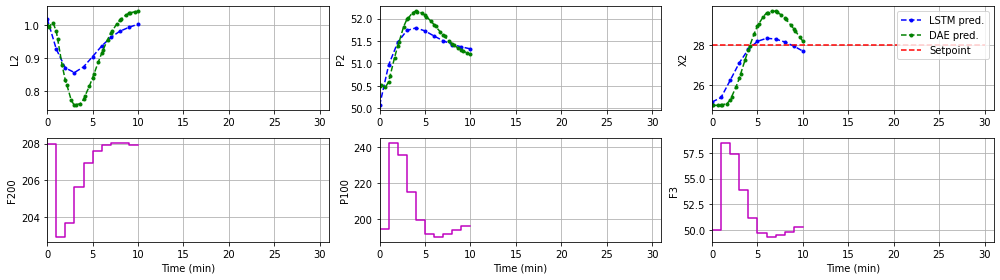

Horizon: 1 min to 11 min
IPOPT took 3.4273 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


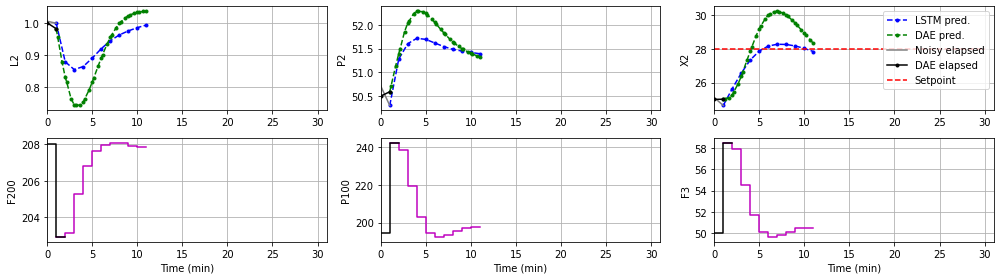

Horizon: 2 min to 12 min
IPOPT took 3.3926 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


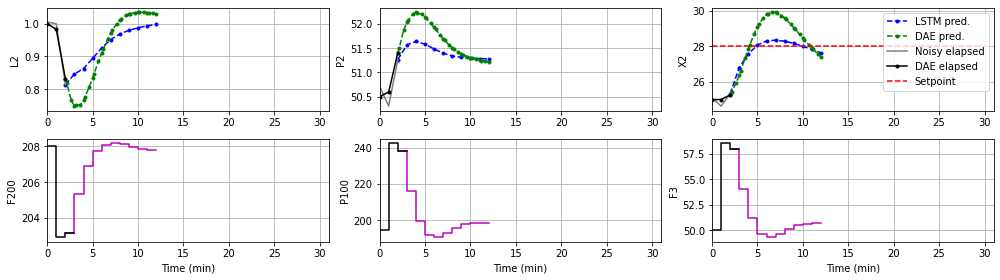

Horizon: 3 min to 13 min
IPOPT took 4.1883 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


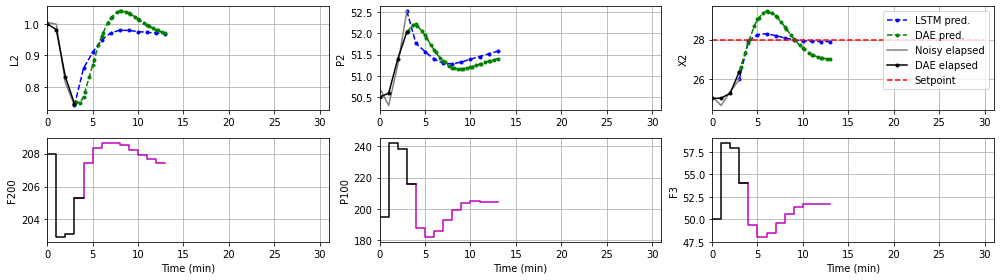

Horizon: 4 min to 14 min
IPOPT took 4.2373 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


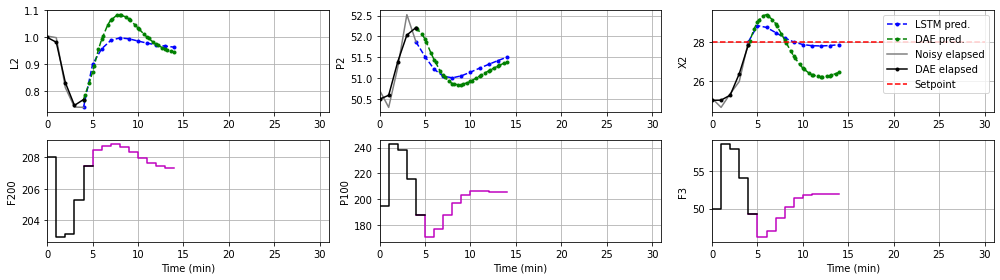

Horizon: 5 min to 15 min
IPOPT took 3.5300 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


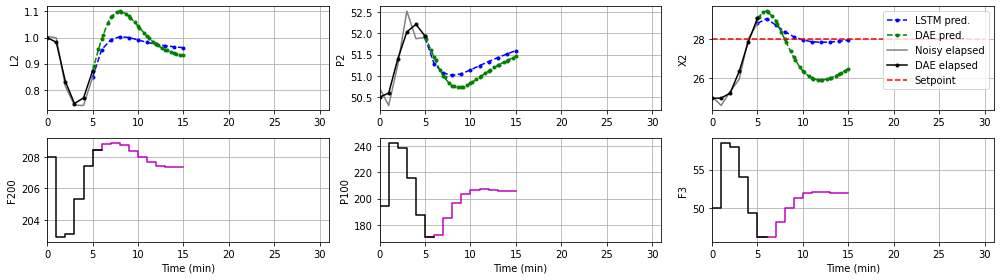

Horizon: 6 min to 16 min
IPOPT took 3.5481 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


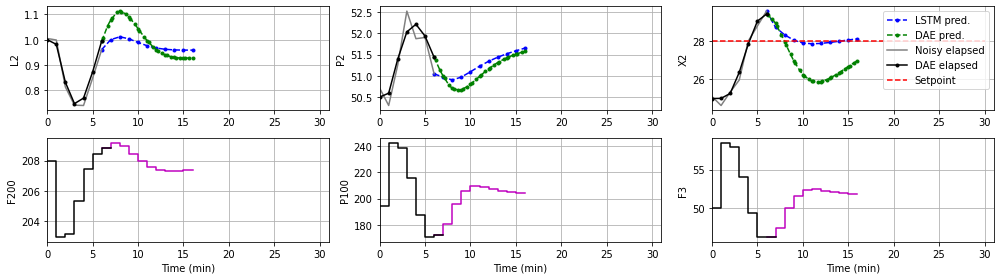

Horizon: 7 min to 17 min
IPOPT took 3.6262 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


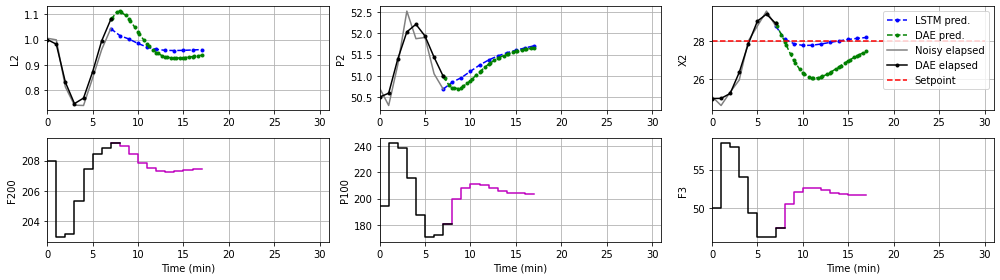

Horizon: 8 min to 18 min
IPOPT took 4.1379 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


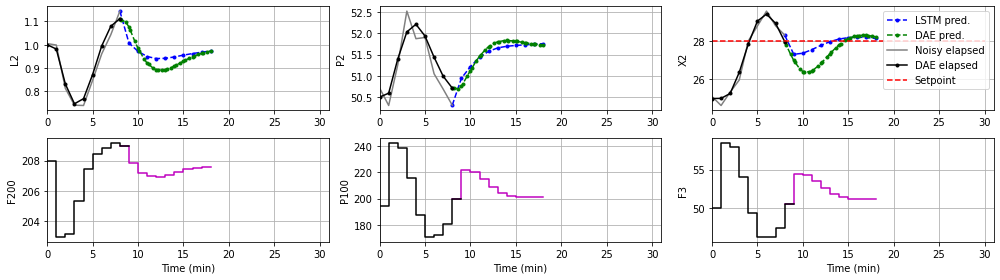

Horizon: 9 min to 19 min
IPOPT took 3.6866 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


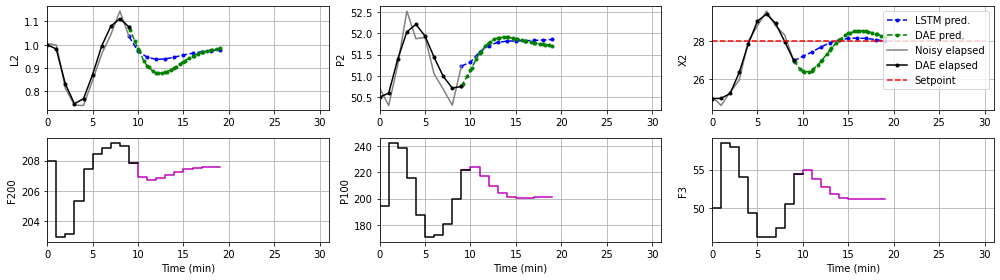

Horizon: 10 min to 20 min
IPOPT took 3.4549 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


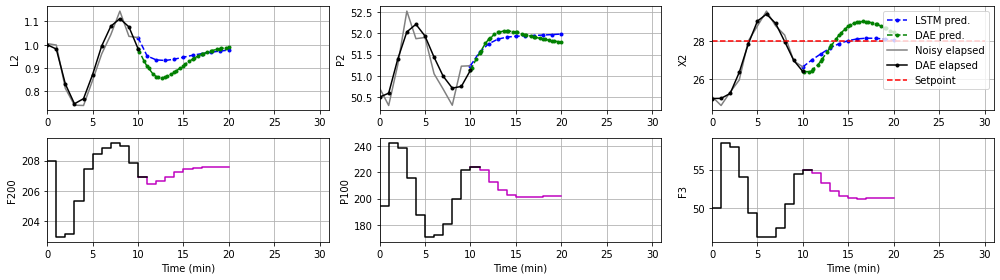

Horizon: 11 min to 21 min
IPOPT took 3.4974 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


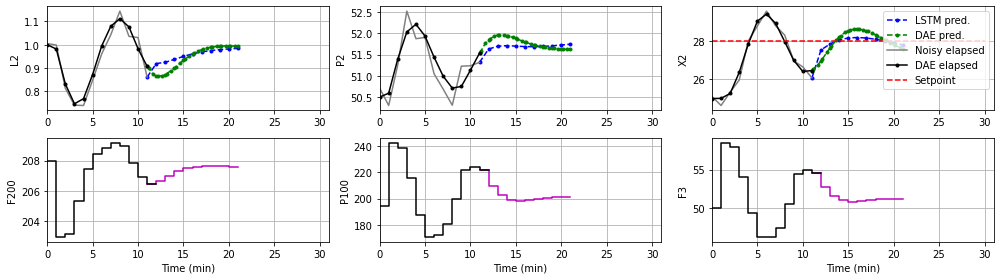

Horizon: 12 min to 22 min
IPOPT took 3.3350 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


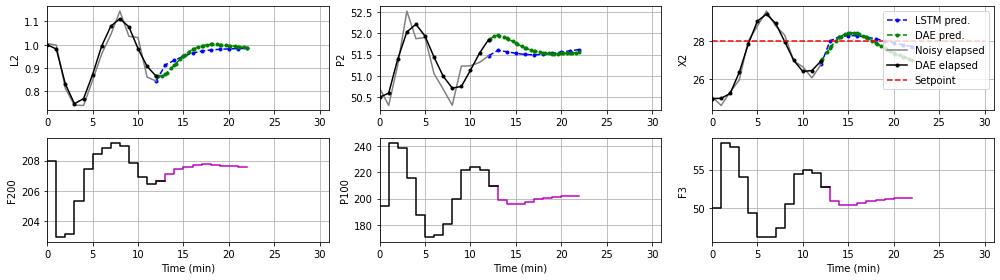

Horizon: 13 min to 23 min
IPOPT took 3.4736 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


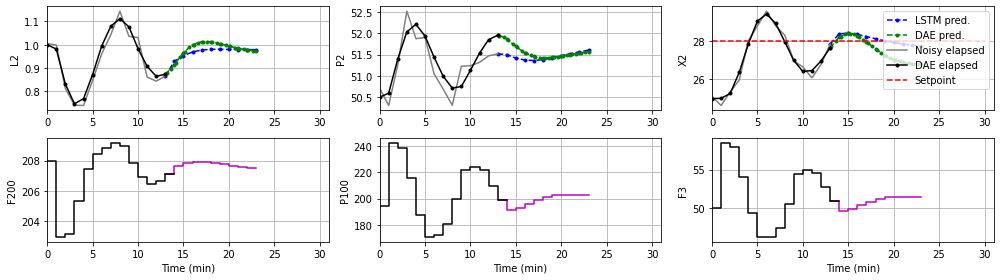

Horizon: 14 min to 24 min
IPOPT took 3.3260 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


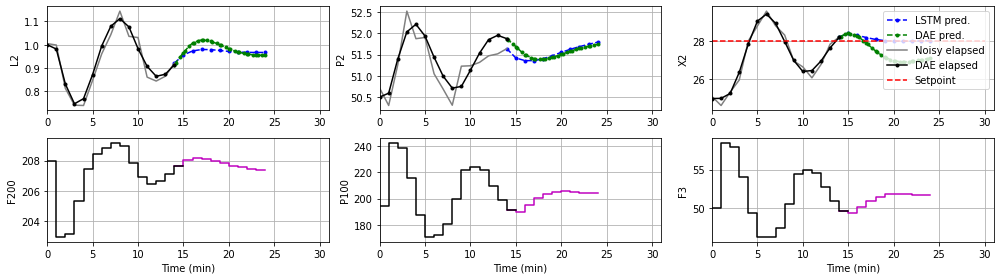

Horizon: 15 min to 25 min
IPOPT took 3.4610 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


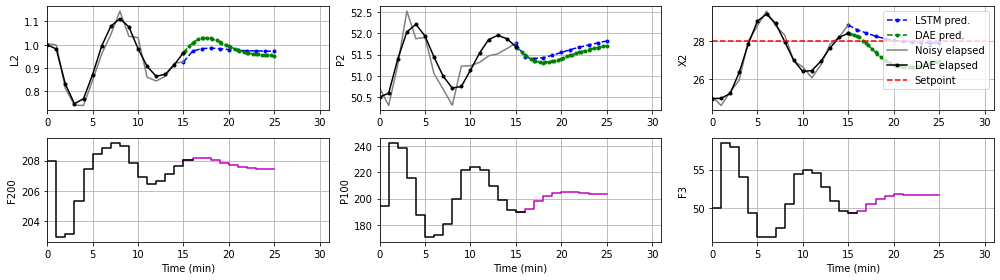

Horizon: 16 min to 26 min
IPOPT took 3.5275 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


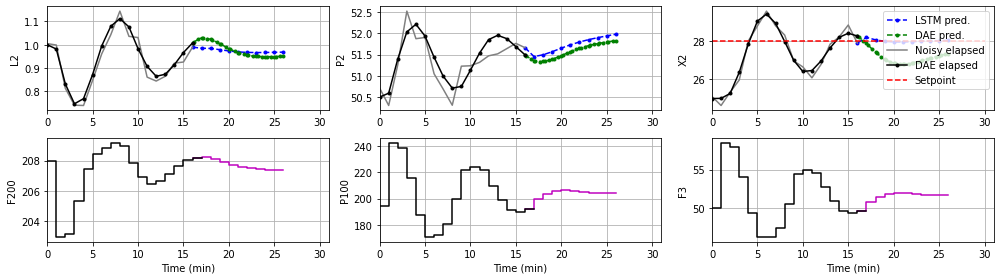

Horizon: 17 min to 27 min
IPOPT took 3.3423 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


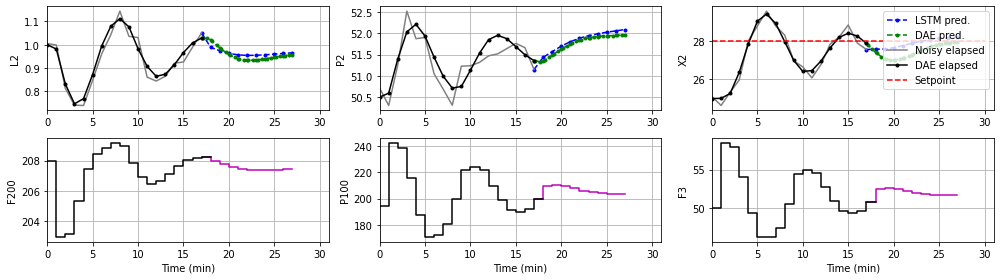

Horizon: 18 min to 28 min
IPOPT took 3.2937 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


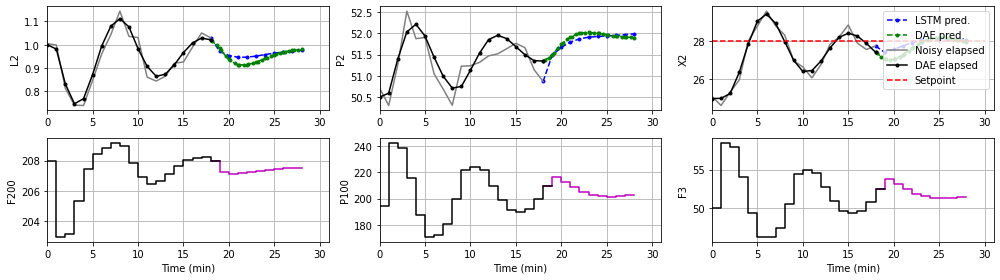

Horizon: 19 min to 29 min
IPOPT took 3.4403 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


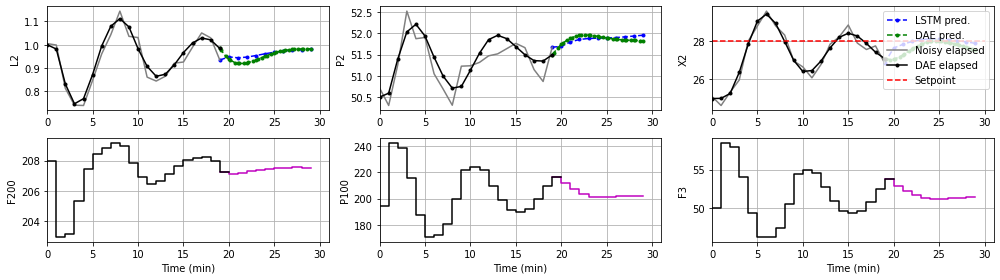

Horizon: 20 min to 30 min
IPOPT took 3.3587 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
Pyomo Status: ok


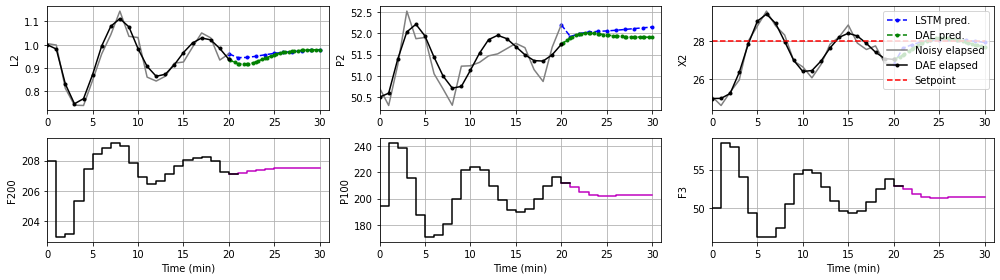

In [5]:
N_hor = 10                  # Prediction horizon
N_iter = 21                 # No. of MPC iterations
X2_sp = 28                  # Setpoint for X2
nvar = (N_hor-1)*len(UI)    # No. of decision variables for IPOPT

np.random.seed(0)

# Pre-allocate arrays for saving results
u_save = np.zeros((N_iter+1, len(UI)))
ipopt_save = np.zeros((N_iter, nvar))
ipopt_time = []
dae_save = []
mdl_save = np.zeros((N_iter, (N_hor + 1)*len(YI)))
y_lstm_save = np.zeros((N_iter+1, len(YI)))
y_pyomo_save = np.zeros((N_iter+1, len(YI)))
y_noisy = np.zeros((N_iter+1, len(YI)))

# Initialize the LSTM model
look_back = 15
uy0 = np.array((208, 194.7, 50, 1, 50.5, 25)*look_back).reshape(-1, 6)

# Initialize the Pyomo DAE model
init_data = {'L2':1, 'P2':50.5, 'X2':25, 'F2':2, 
             'F200': uy0[-1, 0], 'P100': uy0[-1, 1], 'F3': uy0[-1, 2],
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}
u_names = ['F200', 'P100', 'F3']

# Save initial condition
u_save[0, :] = uy0[-1, UI].ravel()
y_lstm_save[0, :] = uy0[-1, YI].ravel()
y_pyomo_save[0, :] = uy0[-1, YI].ravel()

# Add noise to y0 (LSTM only sees uy0)
noise = (np.random.rand(look_back, len(YI))-0.5)*np.array([0.1, 1, 1])
uy0[:, YI] = uy0[:, YI] + noise
y_noisy[0, :] = uy0[0, YI]

# ROLLING HORIZON MPC
for t in range(N_iter):

    # Solve control moves using IPOPT
    start = time()
    nlp = cyipopt.problem(n=nvar,
                          m=0,
                          problem_obj=NLP_MPC(uy0, X2_sp),
                          lb=np.zeros(nvar),
                          ub=np.ones(nvar))

    nlp.addOption('tol', 1e-2)
    init_guess = 0.5 + np.zeros(nvar)
    if t >= 1:
        init_guess = np.hstack((res[3:], res[-3:]))
    
    res, info = nlp.solve(init_guess)
    ipopt_save[t, :] = res
    ipopt_time.append(time() - start)

    print(f'Horizon: {t} min to {t+N_hor} min')
    print(f"IPOPT took {ipopt_time[-1]:.4f} sec.")
    print(info['status_msg'])

    # Implement the control moves on the LSTM surrogate
    # Note: y already contains y0
    
    u_res = (res.reshape(-1, 3)-0.5) * np.array([100, 100, 20]) + \
                                       np.array([208, 194.7, 50])   # nominal condition
    u_res = np.vstack((uy0[-1, UI], u_res))
    y = sim_mpc(uy0, u_res)
    mdl_save[t, :] = y.ravel()

    # Implement the control moves on the Pyomo model
    F200data, P100data, F3data = u_res[:, 0], u_res[:, 1], u_res[:, 2]

    evap_df, pyomo_res = solve_model(t, t+u_res.shape[0], F200data, P100data, F3data, N_hor, init_data)
    print(f"Pyomo Status: {pyomo_res.Solver.status}")

    # Replace the init_data with conditions at next sampling instant
    for k in init_data.keys():
        init_data[k] = evap_df[k].iloc[3]
        
    dae_save.append(evap_df.iloc[:, :3].to_numpy())
    
    # Get latest known y
    y_last = evap_df.iloc[3, :3].to_numpy()
    
    # Replace u0, y0 with conditions at next sampling instant
    u0 = u_res[1, :]
    
    #y0 = y[1, :]   # LSTM does NOT have access to last known y from Pyomo
    #y0 = y_last    # LSTM does have access to last known y from Pyomo
    
    # LSTM does have access to latest y but it's noisy
    y0 = y_last + (np.random.rand(3)-0.5)*np.array([0.1, 1, 1])
    
    # Recede uy0 for 1 time step
    uy0 = np.hstack((np.vstack((uy0[1:, UI], u0)),
                     np.vstack((uy0[1:, YI], y0))))
    
    # Save results
    u_save[t+1, :] = u0
    y_lstm_save[t+1, :] = y[1, :]
    y_pyomo_save[t+1, :] = y_last
    y_noisy[t+1, :] = y0
    
    # Plot current results
    plt.figure(figsize=(14, 4))
    
    for j in range(3):
        plt.subplot(2, 3, j+1)
        plt.plot(t + np.arange(0, len(y)), y[:, j], 'b.--', label='LSTM pred.')
        plt.plot(evap_df.index, evap_df.iloc[:, j], 'g.--', label='DAE pred.')
        if t >= 1:
            plt.plot(np.arange(0, t+1), y_noisy[:t+1, j], c='0.5', label='Noisy elapsed')
            plt.plot(np.arange(0, t+1), y_pyomo_save[:t+1, j], 'k.-', label='DAE elapsed')
        plt.ylabel(evap_df.columns[j])
        plt.xlim([0, N_iter+N_hor])
        plt.grid()
        if j == 2:
            plt.step(np.arange(0, N_hor+N_iter), 
                     np.repeat(X2_sp, N_hor+N_iter), 
                     'r--', where='post', label='Setpoint')
            plt.legend(loc='upper right')
        
        plt.subplot(2, 3, j+4)
        plt.step(t + np.arange(0, u_res.shape[0]+1), 
                 np.hstack((u_res[:, j], u_res[-1, j])), # Repeat the last element
                 where='post', c='m')                    # Zero-order hold 'post' the change
        if t >= 1:
            plt.step(np.arange(0, t+2), np.hstack((u_save[:t+1, j], u_save[t, j])), 
                     where='post', c='k')
        plt.ylabel(u_names[j])
        plt.xlim([0, N_iter+N_hor])
        plt.xlabel('Time (min)')
        plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Reset Keras memory for next horizon
    K.clear_session()

In [7]:
# Calculate IAE
IAE = np.sum(np.abs(y_pyomo_save[:, 2] - X2_sp))
print(f"IAE: {IAE:.4f}")

# Save all results in a json file
all_data = {}
all_data['u_save'] = u_save.tolist()
all_data['ipopt_save'] = ipopt_save.tolist()
all_data['ipopt_time'] = ipopt_time
all_data['dae_save'] = np.stack(dae_save, axis=2).tolist()
all_data['mdl_save'] = mdl_save.tolist()
all_data['y_lstm_save'] = y_lstm_save.tolist()
all_data['y_pyomo_save'] = y_pyomo_save.tolist()
all_data['y_noisy_save'] = y_noisy.tolist()

with open(f'lstm_SPT{X2_sp}_outputs.json', 'w') as f:
    json.dump(all_data, f)

IAE: 23.6254
